# Reinforcement Learning

- A brief introduction to dynamic programming, reinforcement learning, and Q-functions.
- This offers an idea of the concepts needed to understand Deep-Q learning.
- General class notes on RL: https://srdas.github.io/RLBook2/

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Introduction

Reinforcement Learning (RL) has become popular in the pantheon of deep learning with video games, checkers, and chess playing algorithms. DeepMind trained an RL algorithm to play Atari, [Mnih et al (2013)](http://adsabs.harvard.edu/abs/2013arXiv1312.5602M). More recently, just two years ago, DeepMind's Go playing system used RL to beat the world's leading player, Lee Sedol, and [Silver at al  (2016)](https://www.nature.com/articles/nature16961) provides a good overview of their approach. There are many good books one may refer to for RL. See for example, [Sutton and Barto (1998)](https://mitpress.mit.edu/books/reinforcement-learning); [Sutton and Barto (2015)](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf);  [Sugiyama (2015)](https://doc.lagout.org/science/Artificial%20Intelligence/Machine%20learning/Statistical%20Reinforcement%20Learning_%20Modern%20Machine%20Learning%20Approaches%20%5BSugiyama%202015-03-26%5D.pdf). In the area of finance, there has been intermittent progress over the years, as dynamic programming has been scaled up using RL, as evidenced by many papers: [Moody and Saffell (2001)](https://ieeexplore.ieee.org/document/935097); [Dempster and Leemans (2006)](https://www.sciencedirect.com/science/article/pii/S0957417405003015?via%3Dihub); [Corazza and Bertoluzzo (2016)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2507826); [Duarte (2017)](https://www.researchgate.net/publication/319562786_Macro_Finance_and_Macro_Finance_Solving_Nonlinear_Models_in_Continuous_Time_with_Machine_Learning); and [Jiang, Xu, Liang (2017)](https://arxiv.org/abs/1706.10059).

RL is the deep learning application of the broader arena of dynamic programming. It is an algorithm that attempts to maximize the long-term value of a strategy by optimal action at every point in time, where the action taken depends on the state of the observed system. All these constructs are determined by functions of the state $S$ of the system. The value of the long-term strategy is called the "value" function $V(S)$,and the optimal action at any time is known as the decision or "policy" function $P(S)$. Note that the state may also include the time $t$ at which the system is observed.

## Dynamic Programming

Dynamic programming (DP) was formalized by Richard Bellman in his pioneering book, see [Bellman (1957)](https://press.princeton.edu/titles/9234.html). See also [Howard (1966)](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.12.5.317). We initiate our discussion here with an example of dynamic programming.

## Card Game

Take a standard deck of 52 playing cards, and shuffle it. Given a randomly shuffled set of cards, you are allowed to pick one at a time, replace and reshuffle the deck, and draw again, up to a maximum of 10 cards. You may stop at any time, and collect money as follows. If you have an ace, you get $\$14$. Likewise, a king, queen, and jack return you $\$13, \$12, \$11$, respectively. The remaining cards give you their numeric value. Every time you draw a card, you can decide if you want to terminate the game and cash in the value you hold, or discard the card and try again.

The problem you are faced with is to know when to stop and cash in, which depends on the number of remaining draws $n$, and the current card value $x$ that you hold. Therefore, the **state** of the system at draw $t$ is defined by the current card value $x_t$ and the number of remaining draws, $10-t$, i.e., $S = (x_t,10-t)$. The **policy function** is binary as follows:

$$
P(x_t,10-t) = \{\mbox{Halt} = x_t,\mbox{Continue}=\max[P(x_{t+1},10-(t+1))]\}
$$

The **value function** is likewise a function of the state, i.e., $V(x_t,10-t)$.

These problems are solved using **backward recursion**, also known as dynamic programming. To begin we assume we are at the last draw ($\#10$), having decided to reject all preceding 9 values. The expected value of the draw will be the average of the value of all 13 cards ranging from 2 to 14, i.e., $(2+3+...+13+14)/13 = 8$. The expected value of the strategy is

$$
E_{10}[V(x_{10},0)] = 8
$$

Now, roll back to $t=9$, and work out the optimal policy function. We already know that if we hold on till $t=10$, our expected value is 8. So if $x_9 < 8$, we hold on, else we terminate the strategy if $x_9 \geq 8$. (Note that if we are risk averse, we prefer 8 now than the expected value of 8 in the next draw.) The expected value of the strategy is:

$$
E_9[V(x_9,1)] = (8+9+10+11+12+13+14) \cdot \frac{1}{13} + 8 \cdot \frac{6}{13} = 9.615385
$$

Now, roll back to $t=8$. We have worked out that if we hold on till $t=9$, our expected value is 9.62. So if $x_8 \leq 9$, we "Continue", else we "Halt" the strategy if $x_8 \geq 10$. The expected value of the strategy is:

$$
E_8[V(x_8,2)] = (10+11+12+13+14) \cdot \frac{1}{13} + 9.615385 \cdot \frac{8}{13} = 10.53254
$$

And so on ...

We can write a small program to solve the entire problem with the policy cutoffs at each $t$.

In [2]:
import numpy as np

# Dynamic Program to solve the cards problem
T = 10
cards = np.arange(2, 15)  # Equivalent to 2:14 in R
n = len(cards)
V = np.zeros(10)  # Value of optimal policy at each t
P = np.zeros((13, 10))  # Policy {0,1} for all possible cards x at all t

t = 9  # Python uses 0-based indexing, so adjust t accordingly
V[t] = np.mean(cards)
print(t + 1, V[t])  # Adjust t for printing to match R output
for t in range(8, -1, -1):  # Iterate in reverse from 8 to 0
    idx = np.where(cards >= V[t + 1])
    V[t] = np.sum(cards[idx]) / n + V[t + 1] * (n - len(cards[idx])) / n
    P[idx, t] = 1
    print(t + 1, V[t])  # Adjust t for printing to match R output

10 8.0
9 9.615384615384617
8 10.532544378698226
7 11.137915339098772
6 11.56762718392213
5 11.898174756863177
4 12.152442120663983
3 12.359758717484908
2 12.53518045325646
1 12.683614229678543



As we can see from the first set of values, $V_t$, the expected value of the strategy is the highest with a large number of remaining draws. And then declines as we get closer to the end. The table of the policy function $P_t$ shown next, has the card values on the rows and the draw number on the columns.



In [3]:
P = np.c_[np.arange(2, 15), P]
P[:, T] = 1
print(P)

[[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 7.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 8.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
 [ 9.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
 [10.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
 [11.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.]
 [12.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.]
 [13.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [14.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]


The first column above gives the card values. The next 10 columns show the 10 draws, with each column containing values $\{0,1\}$, where $0$ stands for "Continue" and $1$ stands for "Halt". Clearly if you draw a high value card, you will halt sooner.

To summarize, the vector $V$ showed the value function at each $t$, and the matrix $P$ shows the decision rule for each $x_t$. Notice that the problem was solved using "backward recursion". The value of the entire 10 draws at the beginning of the strategy is $12.68$, and is obtained from the value function.

Where does deep learning (specifically RL) enter this problem setting? The short answer is that when the state space $S$ becomes too large, it is hard to find explicit functions for the optimal policy function and the value function. These are then approximated using deep neural nets.

## Random Policy Generation

In the preceding analysis, we have calculated the exact policy for all states $(x_t,T-t)$. This is in the form of the policy function $P(x_t,T-t)$, which in the example above was a decision to terminate the game (value 1) or continue (value 0), presented in a grid $P$ of dimension $13 \times 10$.

Rather than use backward recursion, we may instead employ random policy generation. This would entail random generation of policies in a grid of the same dimension, i.e., populate the grid with values $\{0,1\}$, and then assess the value function using the policy grid for a large random set of draws. Hence, the random policy is discovered in two steps:

1. Generate 10,000 paths of 10 card draws, i.e., a sequence of 10 numbers randomly generated from values $2,3,...,13,14$.
2. Generate 1,000 random policy grids, and assess each one for expected value, i.e., determine the value function.

First, we generate the random draws.

In [4]:
#Generate the random paths of card draws
T = 10
m = 10000
draws = np.random.randint(2, 15, size=(m, T))


Next, we generate the policy functions and assess them for which one is best.



In [5]:
#Generate random policy functions in a list
n_policies = 1000
policies = []
for j in range(n_policies):
  pol = np.round(np.random.rand(13, T))  # Generate random policy matrix
  pol[:, T - 1] = 1  # Set last column to 1 (0-based indexing)
  policies.append(pol)  # Add policy to list

In [6]:
# An example policy function
pol

array([[0., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 1., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0., 1., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 1., 0., 1., 1., 0., 1.],
       [0., 0., 1., 0., 1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 1.],
       [1., 1., 1., 1., 0., 1., 0., 0., 0., 1.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 1.]])


We write a function that evaluates each policy for its expected value over all 10,000 games in the **draws** matrix.



In [7]:
#game is a row of 10 cards; policy is a 13x10 matrix
def valueGP(game, policy):
  t = 0
  for card in game:
    t += 1  # Increment t by 1
    if policy[card - 2, t - 1] == 1:  # 0-based indexing
      break
  return card

def valueFN(draws, policy):
  v = np.zeros(draws.shape[0])  # Use draws.shape[0] for number of rows
  for j in range(draws.shape[0]):
    v[j] = valueGP(draws[j, :], policy)  # Pass the row of draws
  return np.mean(v)


We test all policies over all games.



In [8]:
%%time
value_functions = np.zeros(n_policies)
for j in range(n_policies):
    value_functions[j] = valueFN(draws, policies[j])

CPU times: user 20.5 s, sys: 309 ms, total: 20.8 s
Wall time: 33.3 s



Find the policy with the highest value.



In [9]:
%%time
idx = np.argmax(value_functions)  # Find index of maximum value
print(f"Value function for best policy = {value_functions[idx]}")  # Print the value
best_policy = policies[idx]  # Get the best policy
print(best_policy)  # Print the best policy

Value function for best policy = 9.6976
[[0. 0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1. 0. 1. 1. 1.]
 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]]
CPU times: user 965 µs, sys: 0 ns, total: 965 µs
Wall time: 961 µs




We can see that this is hardly an optimal policy, as the analytical solution has a value function of $12.68361$. We can see that the policy grid is very different from the optimal one, which has 0s in the upper region and 1s in the lower region.

You can see that Monte Carlo is not an ideal optimization strategy as it is hardly exhaustive. The total number of policies that are possible even in this small case is $2^{13 \times 10}$, which is HUGE.

## Policy Gradient Search

In this modeling approach we assess each point in the $13 \times 10$ policy grid and determine if flipping the value improves the value function. In this way we hope to use gradient approach in a simple way. To start with we randomly generate policy matrix $P$. We will work this by going down the columns of the policy matrix $P$. Starting with the first element of the first column, holding all other cells of $P$ constant, we evaluate the policy for both values of $P(1,1) \in \{0,1\}$, and then we set it to be the value that returns the best value function. We then move on to trying both values of $P(2,1)$ and again choose the best one. We proceed like this through all cells of the policy matrix. This completes one epoch, and generates a new policy matrix. We can repeat this process for as many epochs as we like, till the improvement in the value function is immaterially small.

In [10]:
# Randomly generate an initial policy function
# Assuming T, draws, and valueFN are already defined

pol = np.round(np.random.rand(13, T))  # Generate random policy matrix
pol[:, T - 1] = 1  # Set last column to 1 (0-based indexing)
v = valueFN(draws, pol)  # Initial value function

for epoch in range(1, 4):  # Iterate over epochs 1 to 3
    for j in range(T - 1):  # Iterate over columns (0 to T-2)
        for i in range(13):  # Iterate over rows (0 to 12)
            x = pol[i, j]
            pol_new = pol.copy()  # Create a copy of pol
            pol_new[i, j] = abs(x - 1)  # Flip the bit
            v_new = valueFN(draws, pol_new)
            if v_new >= v:
                v = v_new
                pol = pol_new.copy()  # Update pol with the new policy
    print(f"Epoch {epoch} value function = {v}")  # Print epoch and value function

Epoch 1 value function = 11.6376
Epoch 2 value function = 12.6023
Epoch 3 value function = 12.6716



This simple approach is run over three epochs, i.e., we adjust each of the policy function weights thrice, taking one weight gradient at a time. The final value function is very close to the optimal value from the analytical solution. The policy function is as follows.



In [11]:
pol

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

It appears to be very close to the one generated analytically.

## Q-Learning

Here is a Tabular-Q RL formulation of the problem that we discussed above.  We will use a grid-based function to describe the relationship between the state, policy, and value function. (Later, we will use deep learning nets (DLNs) to approximate this function.) We determine the "state-action" function, also known as the $Q(S,A)$ function, where $S$ is the state, and $A$ is the action (both possibly residing in high-dimension tensors). In our cards problem, state $S=\{x,n\}$ and action $A=\{0,1\}$. A didactic exposition follows. The function $Q(S,A)$ stores the current best learned value of optimal action $A$ at each state $S$, and through iteration over simulated game play, it gets better and better. This is the essence of reinforcement $Q$-learning.

*Useful References*

- https://en.wikipedia.org/wiki/Markov_decision_process
- https://en.wikipedia.org/wiki/Q-learning
- https://en.wikipedia.org/wiki/Temporal_difference_learning
- https://en.wikipedia.org/wiki/State%E2%80%93action%E2%80%93reward%E2%80%93state%E2%80%93action
- http://mnemstudio.org/path-finding-q-learning-tutorial.htm

## Implementation in Python

Our implementation will be in Python. We first establish some basic input parameters that we will need. We designate the vector "cards" to hold the value of each card, where recall that, aces equal 14. We define the number of periods $N=10$ and the number of card values $M=13$ as constants for our problem.



In [12]:
cards = [2,3,4,5,6,7,8,9,10,11,12,13,14] #2 to Ace
N = 10 # number of periods
M = 13 # cards

Since simulation will be used to solve the problem, we need to generate a set of  $N$ card draws, which constitutes one instance of a game. We use the *randint* function here.

In [13]:
# Function to return a set of sequential card draws with replacement
from random import randint
def onecard():
    return randint(2,M+1)

def game(N):
    game = [onecard() for j in range(N)]
    return game

print(game(N))

[2, 6, 10, 6, 5, 14, 3, 9, 8, 7]


The output is a random set of $N$ card values, drawn with replacement. Every time this code block is run, we will get a different set of $N$ cards.

## State-Action Reward and $Q$ Tensors

We set up two matrices (tensors) for the $Q(x,n;A)$ function and the reward function $R(x,n;A)$. These are 3D matrices, one dimension for each of the arguments. The reward matrix is static and is set up once and never changed. This is because it is a one-step reward matrix between $(x,n;A)$ and $(x',n-1;A')$, with the reward in between. ($x'$ and $A'$ are the next period state and action, respectively.) It is often known as the SARSA structure, i.e., the  state-action-reward-state-action algorithm.

We initialize the "reward" matrix which contains the reward in every possible state in the 3D tensor.


In [14]:
#Reward matrix (static)
#initialize
R = np.zeros((M,N,2))  #for M cards, N remaining draws, 2 actions
#When the action is 0="continue" then leave the reward as zero
#When the action is 1="halt" then take card value
for j in range(13):
    R[j,:,1] = j+2
    R[:,N-1,0] = cards


We print out the result below, which is a rather long 2D rendition of the 3D tensor. The structure of the three dimensions is $[x, n, a]$, so that each tableau segment below is for one $x$ (card value). The rows below are for each draw $n$ and the columns are for each action $a=\{0,1\}$. Note that for all $n<N$, the reward value of action $a=0$ is zero, as the player does not cash out. For all $n<N$, the reward is $x$, the card value. Only at $n=N$ do we see that $R(x,n;a)=x$, because you will take whatever you get in the final card draw (see that the entire last row in each tableau is $x$). The reward matrix remains fixed throughout the run of the algorithm.

In [15]:
# Check
R

array([[[ 0.,  2.],
        [ 0.,  2.],
        [ 0.,  2.],
        [ 0.,  2.],
        [ 0.,  2.],
        [ 0.,  2.],
        [ 0.,  2.],
        [ 0.,  2.],
        [ 0.,  2.],
        [ 2.,  2.]],

       [[ 0.,  3.],
        [ 0.,  3.],
        [ 0.,  3.],
        [ 0.,  3.],
        [ 0.,  3.],
        [ 0.,  3.],
        [ 0.,  3.],
        [ 0.,  3.],
        [ 0.,  3.],
        [ 3.,  3.]],

       [[ 0.,  4.],
        [ 0.,  4.],
        [ 0.,  4.],
        [ 0.,  4.],
        [ 0.,  4.],
        [ 0.,  4.],
        [ 0.,  4.],
        [ 0.,  4.],
        [ 0.,  4.],
        [ 4.,  4.]],

       [[ 0.,  5.],
        [ 0.,  5.],
        [ 0.,  5.],
        [ 0.,  5.],
        [ 0.,  5.],
        [ 0.,  5.],
        [ 0.,  5.],
        [ 0.,  5.],
        [ 0.,  5.],
        [ 5.,  5.]],

       [[ 0.,  6.],
        [ 0.,  6.],
        [ 0.,  6.],
        [ 0.,  6.],
        [ 0.,  6.],
        [ 0.,  6.],
        [ 0.,  6.],
        [ 0.,  6.],
        [ 0.,  6.],
        [ 6.

## Q-Learning Algorithm

Our reinforcement algorithm learns $Q(x,n;a)$ by playing the game over and over, refining the $Q$-tensor through one epoch after another. The algorithm is described below.

- System State: $(x, n)$, where $x$ is the number of the card drawn at random, $n$ is the number of steps to go. For example $n = 10$ at the start of experiment, and the experiment stops when $n = 0$.
- Iteration (below) is used to compute $Q(x,n; A)$, where $A$ is the action and can take on take values of (i) $A = 0$, i.e., continue the experiment and transition to the next state $(x', n-1)$, with a reward = $0$;  (ii) $A = 1$, i.e., stop the experiment, reward = $x$.
- Initialize the $Q$-tensor to some initial values ($=0$), initialize to some state $(x, n)$, and repeat the following steps in a loop until remaining draws $n = 0$:

1. Compute $Q(x,n;0)$ and $Q(x,n;1)$.
2. If $Q(x,n, 0) > Q(x, n, 1)$, then choose Action 0, otherwise choose Action 1.
3. If the Action chosen is 0, then transition to next state $(x',n-1)$, where $x'$ is chosen using a transition probability model. In the cards case, this probability is uniform across all states.
4. Compute $Q(x',n-1,0)$ and $Q(x',n-1,1)$ using the DLN. Choose the next Action $A'$ depending upon which of these is larger.
5. Update the $Q$ value of the original state using
   - $Q(x,n,0) \leftarrow Q(x,n,0) + \alpha[0 + \gamma Q(x',n-1,A')-Q(x,n,0)]$
   - $Q(x,n,1) \leftarrow (1-\alpha) Q(x,n,1) + \alpha x$
   - $\gamma \leq 1$.
6. If $A = 1$ or $n = 0$, then re-initialize to some random $x$ and go back to step 1. Otherwise set $x \leftarrow x'$ and  $A \leftarrow A'$ and go back to step 1.

Learning rate $\alpha$ is a hyperparameter, we start by setting it to 0.1. Also $\gamma$ is the discount factor in the reward function.

In the following code, we develop the $Q$-function via Monte Carlo simulation. The function below contains the logic for executing one card draw, and the learning procedure therefrom. Given the state $S=\{x,n\}$, the action $A=\{0,1\}$ is drawn at random with equal probability to generate the reward $R$ and also generate the next state $S'=\{x',n+1\}$. We then consider the reward from optimal action $A'$ next period. This reward will be the better of the two possible $Q$ values next period, i.e., $\max[Q(x',n+1;A=0), Q(x',n+1;A=1)]$. The functional form is as follows when $A=0$, i.e., when the action is to hold on for another draw.


$$
Q(x,n;A=0) = Q(x,n;A=0) + R(x,n;A=0)  \\
\quad + \gamma \cdot \max[Q(x',n+1;A'=0), Q(x',n+1;A'=1)], \quad \quad (**Qiter**) \\
\quad \quad \quad \quad \mbox{if } A=0
$$

The current "quality" function $Q$ is equal to current reward plus the discounted optimized reward in the following period, based on the conditional randomized state $(x',n+1 | x,n)$ chosen in the following period. Notice that $\gamma$ here is the discount rate. The equation (**Qiter**) above leads to constantly increasing values in the $Q$ tensor, and to normalize the values to be stable, the equation above is updated instead as follows.

$$
\begin{equation}
Q(x,n;A=0) = (1-\alpha) Q(x,n;A=0) + \alpha \left[ R(x,n;A=0) \\
+ \gamma \cdot \max[Q(x',n+1;A'=0), Q(x',n+1;A'=1)] \right]
\end{equation}
$$

Here, $\alpha$ is the "learning rate" of $Q$-learning. Notice that we can further rewrite the equation above as

$$
\begin{equation}
Q(x,n;A=0) = Q(x,n;A=0) + \alpha \left[ R(x,n;A=0) \\
+ \gamma \cdot \max[Q(x',n+1;A'=0), Q(x',n+1;A'=1)] \\
- Q(x,n;A=0) \right]
\end{equation}
$$

The analogous equation to this is used when action $A'=1$ and the game terminates and the reward is collected.

$$
Q(x,n;A=1) = (1-\alpha) Q(x,n;A=1) + \alpha R(x,n;A=0)
$$

All these functions are embedded in the code below.

In [16]:
# Running the Tabular Q-learning algorithm

def doOneDraw(x0,n0):  #assumes that n0<10
    #now, given x0,n0
    a0 = np.random.randint(0,2)    #index of action
    #next
    x1 = np.random.randint(0,M)   #next state
    Q[x0,n0,0] = Q[x0,n0,0] + alpha*(R[x0,n0,0] +
                    gamma*max(Q[x1,n0+1,0],Q[x1,n0+1,1]) - Q[x0,n0,0])
    Q[x0,n0,1] = (1-alpha)*Q[x0,n0,1] + alpha*R[x0,n0,1]
    if a0==0:
        return [x1,n0+1]   #draw another card
    else:
        return [x0,N]     #terminate and take value of current card


This function is then called repeatedly to complete one game, which is called an "epoch". The function that does one epoch is below.

In [17]:
def doOneGame(x):
    n = 0
    while n<(N-1):
        [x,n] = doOneDraw(x,n)
    if n==(N-1):
        Q[x,n,0] = (1-alpha)*Q[x,n,0] + alpha*R[x,n,0]   #in both actions it is the end
        Q[x,n,1] = (1-alpha)*Q[x,n,1] + alpha*R[x,n,1]

Now we can initialize the $Q$ matrix and $\alpha, \gamma$.

In [18]:
#State-Action Value function
#Q-matrix
Q = np.zeros((M,N,2))

alpha = 0.25      #Learning rate
gamma = 1.00      #Discount rate

Finally, we run the entire algorithm for a large number of epochs.

In [19]:
%%time
#Run the epochs
epochs = 100000
Qdiff = np.zeros(epochs)
for j in range(epochs):
    Q0 = np.copy(Q)
    x = randint(0,M-1)
    doOneGame(x)
    Qdiff[j] = sum(((Q - Q0))**2)

CPU times: user 5.22 s, sys: 453 ms, total: 5.67 s
Wall time: 5.38 s


In [20]:
print("Policy Shape =", Q.shape)
print("Value Function")
print(Q[:,:,0])
print(Q[:,:,1])

Policy Shape = (13, 10, 2)
Value Function
[[12.30623922 11.90644136 11.82825912 12.05568036 11.63402321 10.89725455
  10.2015692   8.13669964  7.12078902  1.99365758]
 [12.25744987 12.23694198 12.41509133 11.50761581 11.36161974 10.69071232
  10.23332754  9.61746446  8.3372078   2.99048636]
 [12.45321167 11.99541937 11.79611086 12.20962648 11.34476046 11.38375372
  10.15234957 10.53152985  5.48297695  3.87329459]
 [12.28170822 12.07715787 11.78645736 11.82873141 11.56513903 10.35879788
  11.52185106  8.67131622  5.93661352  4.88121368]
 [12.13910181 12.50313659 12.06234008 11.4266138  11.44731456 11.33739411
   9.31797115 10.92731178  5.71599443  5.99197287]
 [12.30163509 12.05920315 11.83405009 11.64222585 11.0308718  11.03468638
   9.39690874  8.44455064  6.69308134  6.97040202]
 [12.45380825 12.79029479 11.9805417  11.8207713  11.18099002 11.38623696
   9.86847812 10.21028842  7.66625223  7.74658918]
 [12.42773947 12.22903025 12.06576103 11.45810917 11.69649622 11.76849025
  10.6356

In [21]:
# Expected value from best action at the outset
np.maximum(Q[:,0,0], Q[:,0,1]).mean()

12.509371960564213

Now, we can set up the signed value of the difference between actions (do not take card value vs take card value).

In [22]:
# POLICY FUNCTION from the Q Function
signed_matrix = Q[:,:,1] - Q[:,:,0]
binary_matrix = np.where(signed_matrix >= 0, 1, 0)
binary_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

## Convergence

Above the squared pointwise difference between successive tensors is computed by taking the following sum, noting that each scalar value of $Q$ comes from a 3D tensor:

$$
\mbox{Qdiff}_t = \sum_t \left[Q_t - Q_{t-1}\right]^2
$$

This is an oscillating sequence, that trends lower and lower to convergence. To smooth out the oscillations we take the moving average over 1% of the sequence at a time. See next.


The convergence is shown in the figure below

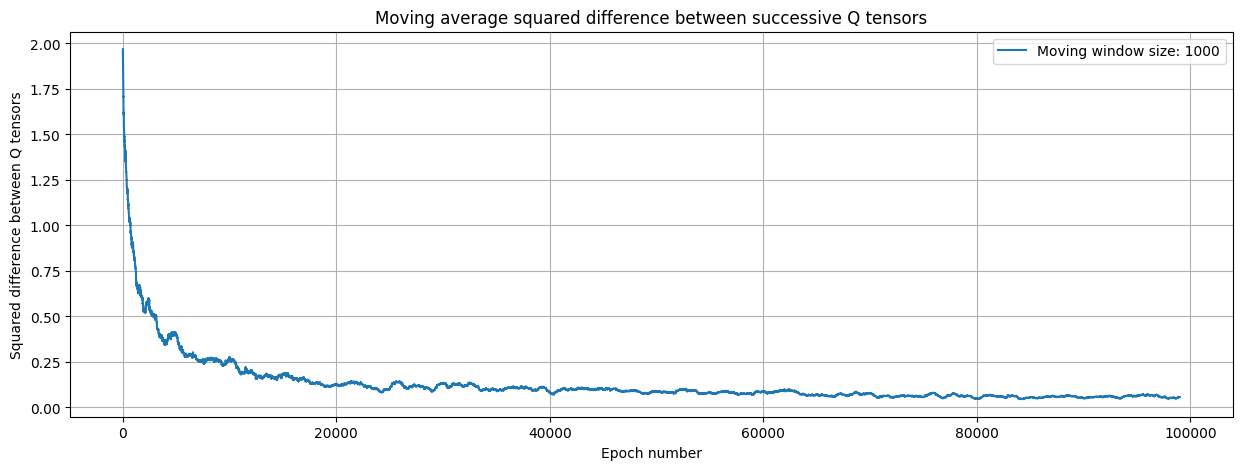

In [23]:
#Plot the Qdiff to see if it declines
window = int(epochs*0.01)
qd = pd.Series(Qdiff)
y = qd.rolling(window).mean()

plt.figure(figsize=(15,5))
plt.plot(range(len(y)-window),y[window:],label='Moving window size: '+str(window))
plt.grid()
plt.xlabel("Epoch number")
plt.ylabel("Squared difference between Q tensors")
# See previous block for error computation plotted here
plt.title("Moving average squared difference between successive Q tensors")
plt.legend()

It is also useful to examine the $Q$ tensor after the algorithm has converged. We examine one slice of the tensor here, for $n=4$.

If you examine the grid below it is of dimension $13 \times 2$ and is the value of $Q(x,4,A)$ for all values of $x,A$ at time $n=4$. This is a 2D slice of the 3D tensor for $Q(x,n,A)$, the state-action value function. It tells us that the optimal action is 1 if the second column is bigger than the first, else action is 0. Clearly it is more optimal to stop at higher card values because the value in column 2 (where A=1) is much higher than in column 1 (where A=0).

In [24]:
#Let's see what it shows for n=4
#The two columns are for A=0 and A=1, rows being card values
Q[:,4,:]

array([[11.63402321,  2.        ],
       [11.36161974,  3.        ],
       [11.34476046,  4.        ],
       [11.56513903,  5.        ],
       [11.44731456,  6.        ],
       [11.0308718 ,  7.        ],
       [11.18099002,  8.        ],
       [11.69649622,  9.        ],
       [12.02470893, 10.        ],
       [11.5141961 , 11.        ],
       [11.23760687, 12.        ],
       [11.99671198, 13.        ],
       [11.44749839, 14.        ]])

## Compute the optimal policy grid from the Q grid

We can use the $Q$ tensor to generate the optimal policy function based on whether $A=0$ or $A=1$ is optimal.



In [25]:
P = zeros((M,N))
P[:,N-1] = 1
for i in range(M):
    for j in range(N):
        if Q[i,j,1] > Q[i,j,0]:
            P[i,j] = 1
print(P)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


We see that this is not the exact optimal $P$ grid that we get from exact dynamic programming. So it is suboptimal. But we can assess the value function from this $P$ grid by running samples below.

The optimal policy grid from dynamic programming was computed above, where the optimal value function is $12.68$.

## Compute expected value function for random sets

We now calculate the value of the optimal policy from $Q$-learning.

Generate 10,000 sets of 10 random card draws, and then execute the strategy in the policy grid above and compute the expected value across all 10,000 sets to get the expected value function. The following code calculates the expected value of implementing the $Q$-learning optimal policy on the random set of games.

We plot the distribution of game outcomes for all games in the figure below.

In [26]:
def Vfunction(N):
    cards = game(N)
    for n in range(N):
        if P[cards[n]-2,n]==1:
            return cards[n]

The following code generates 10,000 games with $N$ card draws each. And then computes the expectd value function across all games.

Expected Value Function E[V(S)] =  12.6382


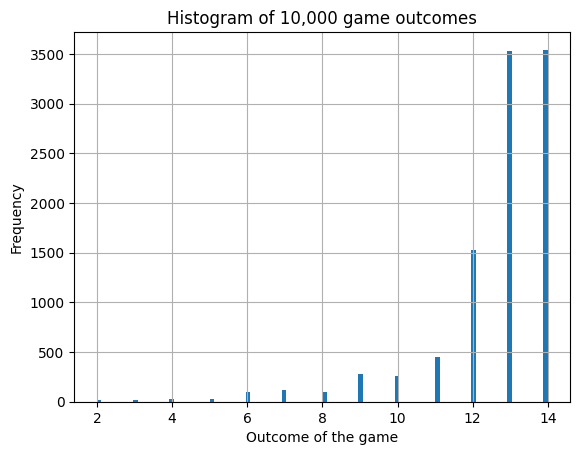

In [27]:
nsets = 10000
V = np.zeros(nsets)
for i in range(nsets):
    V[i] = Vfunction(N)

plt.hist(V,100)
plt.grid()
plt.xlabel('Outcome of the game')
plt.ylabel('Frequency')
plt.title('Histogram of 10,000 game outcomes')

print("Expected Value Function E[V(S)] = ",np.mean(V))

The value function is close to the analytical solution from dynamic programming, i.e., 12.68.

We also note that the solution worsens when we use $\gamma < 1$ because the problem is then different from the one originally solved where we did not treat outcomes at different times differently. So we set $\gamma=1$.

What about the $\alpha$ parameter? It seems to be working well at $\alpha=0.25$.

## Q-learning with Deep Learning Nets vs Dynamic Programming

Using DLNs makes sense only when the size of the state space or the action space is so large, that the usual dynamic programming (DP) procedure cannot be applied. We note also that in RL, unlike in DP, no backward recursion is necessary. Only forward simulation is applied.

## References

- There is an entire set of notes on RL, which may be accessed here: https://srdas.github.io/RLBook2/

- Paper on goals-based portfolio optimization using RL: [Das and Varma (2019)](https://srdas.github.io/Papers/GBWM_RL2.pdf).

- MIT Lecture on Deep RL: https://introtodeeplearning.com/slides/6S191_MIT_DeepLearning_L5.pdf